# Supermarket Loyalty Program
International Essentials, a global supermarket chain, offers a loyalty program that rewards customers annually based on their spending. The more a customer spends, the greater the rewards they receive.

To better estimate the cost of these rewards and predict end-of-year profits, the supermarket aims to forecast the expected spending of loyalty program members. Accurate predictions will help optimize budget planning and overall profitability.

# Loyalty Data Description

The **loyalty.csv** file contains customer loyalty information with the following columns:

- **customer_id**: Unique identifier for each customer.
- **spend**: Total spending amount of the customer.
- **first_month**: Spending amount in the first month after joining.
- **items_in_first_month**: Number of items purchased in the first month.
- **region**: Geographic region where the customer is located.
- **loyalty_years**: Number of years the customer has been in the loyalty program (categorized).
- **joining_month**: The month in which the customer joined the loyalty program.
- **promotion**: Indicates whether the customer joined under a promotional offer (`Yes` or `No`).



In [117]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from yellowbrick.regressor import ResidualsPlot
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor



In [89]:
# Loading and examining the dataset
supermarket_df = pd.read_csv("D:\\loyalty.csv")
supermarket_df = supermarket_df.drop('customer_id', axis=1)
supermarket_df.head(10)

,spend,first_month,items_in_first_month,region,loyalty_years,joining_month,promotion
0,132.68,15.3,5,Asia/Pacific,5-10,Nov,No
1,106.45,16.2,14,Asia/Pacific,0-1,Feb,Yes
2,123.16,25.26,7,Middle East/Africa,10+,Dec,Yes
3,130.60,24.74,8,Middle East/Africa,3-5,Apr,No
4,130.41,25.59,8,Middle East/Africa,3-5,Apr,Yes
5,127.46,21.45,7,Europe,3-5,May,Yes
6,127.17,21.46,14,Middle East/Africa,3-5,NaN,NO
7,125.50,19.11,7,Asia/Pacific,3-5,Jul,Yes
8,106.80,16.01,14,Americas,0-1,Feb,Yes
9,112.28,21.49,7,Europe,0-1,May,NO


In [35]:
supermarket_df.tail(10)

,spend,first_month,items_in_first_month,region,loyalty_years,joining_month,promotion
1236,130.56,26.18,7,Europe,3-5,Dec,No
1237,112.09,20.96,9,Americas,0-1,Jan,No
1238,112.12,13.51,13,Europe,10+,Oct,Yes
1239,130.01,24.97,9,Americas,3-5,Apr,Yes
1240,131.14,.,9,Europe,1-3,Jan,No
1241,126.01,15.97,14,Americas,1-3,NaN,Yes
1242,111.85,21.22,9,Asia/Pacific,0-1,Jan,No
1243,132.51,16.23,9,Middle East/Africa,5-10,Aug,No
1244,131.57,21.21,9,Americas,1-3,NaN,No
1245,135.85,18.99,7,Middle East/Africa,5-10,NaN,No


In [36]:
supermarket_df.shape

(1246, 7)

In [37]:
supermarket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   spend                 1246 non-null   float64
 1   first_month           1246 non-null   object 
 2   items_in_first_month  1246 non-null   int64  
 3   region                1246 non-null   object 
 4   loyalty_years         1246 non-null   object 
 5   joining_month         1121 non-null   object 
 6   promotion             1246 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 68.3+ KB


In [38]:
supermarket_df.describe().round(2)

,spend,items_in_first_month
count,1246.00,1246.00
mean,122.64,9.42
std,9.98,3.00
min,104.29,5.00
25%,112.21,7.00
50%,123.84,9.00
75%,131.09,13.00
max,142.29,15.00


# 1. Proprossising Data

## missing data 

In [39]:
# function to count missing data and in which feature.
def missing_data(data):
    nb_values = data.isnull().sum().sort_values(ascending = False) #contains the number of values missing
    percent_values = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False) #contains the percentage of values missing
    return pd.concat([nb_values, percent_values], axis=1, keys=['Number of Missing Values', 'Percentage of Missing Values'])

missing_data(supermarket_df).head(8)

,Number of Missing Values,Percentage of Missing Values
joining_month,125,10.032103
spend,0,0.000000
first_month,0,0.000000
items_in_first_month,0,0.000000
region,0,0.000000
loyalty_years,0,0.000000
promotion,0,0.000000


## Validation of data & handling missing data

In [40]:
# Create a cleaned version of the dataframe
clean_data = supermarket_df.copy()


# 'spend': Replace missing values with 0
clean_data['spend'] = clean_data['spend'].fillna(0).round(2).astype(float)

# 'first_month': Replace missing values and invalid entries with 0
clean_data['first_month'] = (
    pd.to_numeric(clean_data['first_month'], errors='coerce')  
    .fillna(0)                                                 # Replace NaN with 0
    .round(2)                                                  # Round to 2 decimal places
    .astype(float)                                             # Ensure the column is float
)

# 'items_in_first_month': Replace missing values with 0
clean_data['items_in_first_month'] = clean_data['items_in_first_month'].fillna(0).astype(int)



# 'region': Standardize case, trim whitespace, and replace invalid/missing values
clean_data['region'] = (
    clean_data['region']
    .str.strip()                     # Remove leading/trailing spaces
    .str.lower()                     # Convert to lowercase
    .str.replace(r'\s+', ' ', regex=True)  # Normalize multiple spaces to one space
    .replace({'unknown': 'Unknown'}) # Replace 'unknown' with 'Unknown'
    .fillna("Unknown")               # Replace NaN with "Unknown"
)

# 'loyalty_years': Standardize categories and replace invalid/missing values
valid_loyalty_years = ['0-1', '1-3', '3-5', '5-10', '10+']
clean_data['loyalty_years'] = (
    clean_data['loyalty_years']
    .str.strip()                     # Remove leading/trailing spaces
    .str.lower()                     # Convert to lowercase
    .replace({'0 - 1': '0-1', '1 - 3': '1-3', '3 - 5': '3-5', '5 - 10': '5-10'})  # Standardize formats
    .apply(lambda x: x if x in valid_loyalty_years else '0-1')  # Replace invalid values with '0-1'
    .fillna('0-1')                   # Replace NaN with '0-1'
)

# 'joining_month': Standardize case, trim whitespace, and replace invalid/missing values
valid_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
clean_data['joining_month'] = (
    clean_data['joining_month']
    .str.strip()                     # Remove leading/trailing spaces
    .str.capitalize()                # Capitalize the first letter
    .apply(lambda x: x if x in valid_months else "Unknown")  # Replace invalid months with "Unknown"
    .fillna("Unknown")               # Replace NaN with "Unknown"
)

# 'promotion': Standardize case and map values to 'Yes'/'No'
clean_data['promotion'] = (
    clean_data['promotion']
    .str.strip()                     # Remove leading/trailing spaces
    .str.lower()                     # Convert to lowercase
    .replace({'yes': 'Yes', 'no': 'No', 'y': 'Yes', 'n': 'No'})  # Map variations to 'Yes'/'No'
    .fillna('No')                    # Replace NaN with 'No'
)

# Display the cleaned dataframe
clean_data.head(10)


,spend,first_month,items_in_first_month,region,loyalty_years,joining_month,promotion
0,132.68,15.30,5,asia/pacific,5-10,Nov,No
1,106.45,16.20,14,asia/pacific,0-1,Feb,Yes
2,123.16,25.26,7,middle east/africa,10+,Dec,Yes
3,130.60,24.74,8,middle east/africa,3-5,Apr,No
4,130.41,25.59,8,middle east/africa,3-5,Apr,Yes
5,127.46,21.45,7,europe,3-5,May,Yes
6,127.17,21.46,14,middle east/africa,3-5,Unknown,No
7,125.50,19.11,7,asia/pacific,3-5,Jul,Yes
8,106.80,16.01,14,americas,0-1,Feb,Yes
9,112.28,21.49,7,europe,0-1,May,No


In [41]:
clean_data.tail(10)


,spend,first_month,items_in_first_month,region,loyalty_years,joining_month,promotion
1236,130.56,26.18,7,europe,3-5,Dec,No
1237,112.09,20.96,9,americas,0-1,Jan,No
1238,112.12,13.51,13,europe,10+,Oct,Yes
1239,130.01,24.97,9,americas,3-5,Apr,Yes
1240,131.14,0.00,9,europe,1-3,Jan,No
1241,126.01,15.97,14,americas,1-3,Unknown,Yes
1242,111.85,21.22,9,asia/pacific,0-1,Jan,No
1243,132.51,16.23,9,middle east/africa,5-10,Aug,No
1244,131.57,21.21,9,americas,1-3,Unknown,No
1245,135.85,18.99,7,middle east/africa,5-10,Unknown,No


In [42]:
missing_data(clean_data).head(8)

,Number of Missing Values,Percentage of Missing Values
spend,0,0.0
first_month,0,0.0
items_in_first_month,0,0.0
region,0,0.0
loyalty_years,0,0.0
joining_month,0,0.0
promotion,0,0.0


## Handling categorical columns.

In [48]:
# Identify categorical columns
categorical_cols = ['region', 'loyalty_years', 'joining_month', 'promotion']

# Create dummy variables for categorical columns
data_with_dummies = pd.get_dummies(clean_data, columns=categorical_cols, drop_first=True)

# Convert any boolean columns (True/False) to integers (1/0)
data_with_dummies = data_with_dummies.astype(int)

# Display the first few rows of the transformed dataset
data_with_dummies.head()

,spend,first_month,items_in_first_month,region_asia/pacific,region_europe,region_middle east/africa,loyalty_years_1-3,loyalty_years_10+,loyalty_years_3-5,loyalty_years_5-10,...,joining_month_Jan,joining_month_Jul,joining_month_Jun,joining_month_Mar,joining_month_May,joining_month_Nov,joining_month_Oct,joining_month_Sep,joining_month_Unknown,promotion_Yes
0,132,15,5,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,106,16,14,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,123,25,7,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,130,24,8,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,130,25,8,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Handling Douplicate Data

In [44]:
#Show Duplicates
def check_duplicates(df):
    """Check for duplicate rows in a DataFrame."""
    if df.duplicated().any():
        return "We have duplicate values"
    return "Data is OK without duplicates"


result = check_duplicates(data_with_dummies)
print(result)

We have duplicate values


## spilt data to training and testing

In [66]:
# Define your features (X) and target (y)
X = data_with_dummies.drop('spend', axis=1)  # Features (all columns except 'spend')
y = data_with_dummies['spend']  # Target (the 'spend' column)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


"\n# Continuous columns\nX_train_continuous = X_train[['first_month', 'items_in_first_month']]\nX_test_continuous = X_test[['first_month', 'items_in_first_month']]\n\n# Standardize for use in ML (X using only training data)\nsc_XS = StandardScaler()\nsc_ys = StandardScaler()\n\nX_train_scaled = sc_XS.fit_transform(X_train_continuous)\nX_test_scaled = sc_XS.transform(X_test_continuous)\n\n# Dummies columns\nX_train_dummies = X_train.drop(['first_month', 'items_in_first_month'], axis=1)\nX_test_dummies = X_test.drop(['first_month', 'items_in_first_month'], axis=1)\n\n# Merge the continuous scaled data with the dummy data\nX_train_final_scaled = pd.concat([pd.DataFrame(X_train_scaled, columns=['first_month', 'items_in_first_month']), X_train_dummies], axis=1)\nX_test_final_scaled = pd.concat([pd.DataFrame(X_test_scaled, columns=['first_month', 'items_in_first_month']), X_test_dummies], axis=1)\n"

# 2.Exploratory Data Analysis (EDA)

In [111]:
X_train.describe().round(2)

,first_month,items_in_first_month,region_asia/pacific,region_europe,region_middle east/africa,loyalty_years_1-3,loyalty_years_10+,loyalty_years_3-5,loyalty_years_5-10,joining_month_Aug,...,joining_month_Jan,joining_month_Jul,joining_month_Jun,joining_month_Mar,joining_month_May,joining_month_Nov,joining_month_Oct,joining_month_Sep,joining_month_Unknown,promotion_Yes
count,996.00,996.00,996.00,996.00,996.00,996.00,996.0,996.00,996.0,996.00,...,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.00,996.0,996.00
mean,16.58,9.34,0.24,0.25,0.27,0.19,0.1,0.19,0.2,0.08,...,0.12,0.08,0.06,0.07,0.07,0.07,0.08,0.07,0.1,0.49
std,6.61,3.00,0.43,0.43,0.44,0.39,0.3,0.40,0.4,0.27,...,0.32,0.28,0.23,0.26,0.26,0.26,0.28,0.25,0.3,0.50
min,0.00,5.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,15.00,7.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
50%,18.00,9.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
75%,21.00,13.00,0.00,0.25,1.00,0.00,0.0,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00
max,26.00,15.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00


In [112]:
X_test.describe().round(2)

,first_month,items_in_first_month,region_asia/pacific,region_europe,region_middle east/africa,loyalty_years_1-3,loyalty_years_10+,loyalty_years_3-5,loyalty_years_5-10,joining_month_Aug,...,joining_month_Jan,joining_month_Jul,joining_month_Jun,joining_month_Mar,joining_month_May,joining_month_Nov,joining_month_Oct,joining_month_Sep,joining_month_Unknown,promotion_Yes
count,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.0,250.00,...,250.00,250.00,250.00,250.00,250.0,250.00,250.0,250.00,250.0,250.0
mean,17.31,9.72,0.19,0.28,0.23,0.21,0.08,0.25,0.2,0.05,...,0.12,0.11,0.08,0.06,0.1,0.02,0.1,0.08,0.1,0.5
std,5.96,2.97,0.39,0.45,0.42,0.41,0.28,0.43,0.4,0.22,...,0.32,0.31,0.27,0.24,0.3,0.14,0.3,0.28,0.3,0.5
min,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0
25%,15.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0
50%,19.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,1.0
75%,21.00,13.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,1.0
max,26.00,15.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,...,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.0,1.0


# Distribution

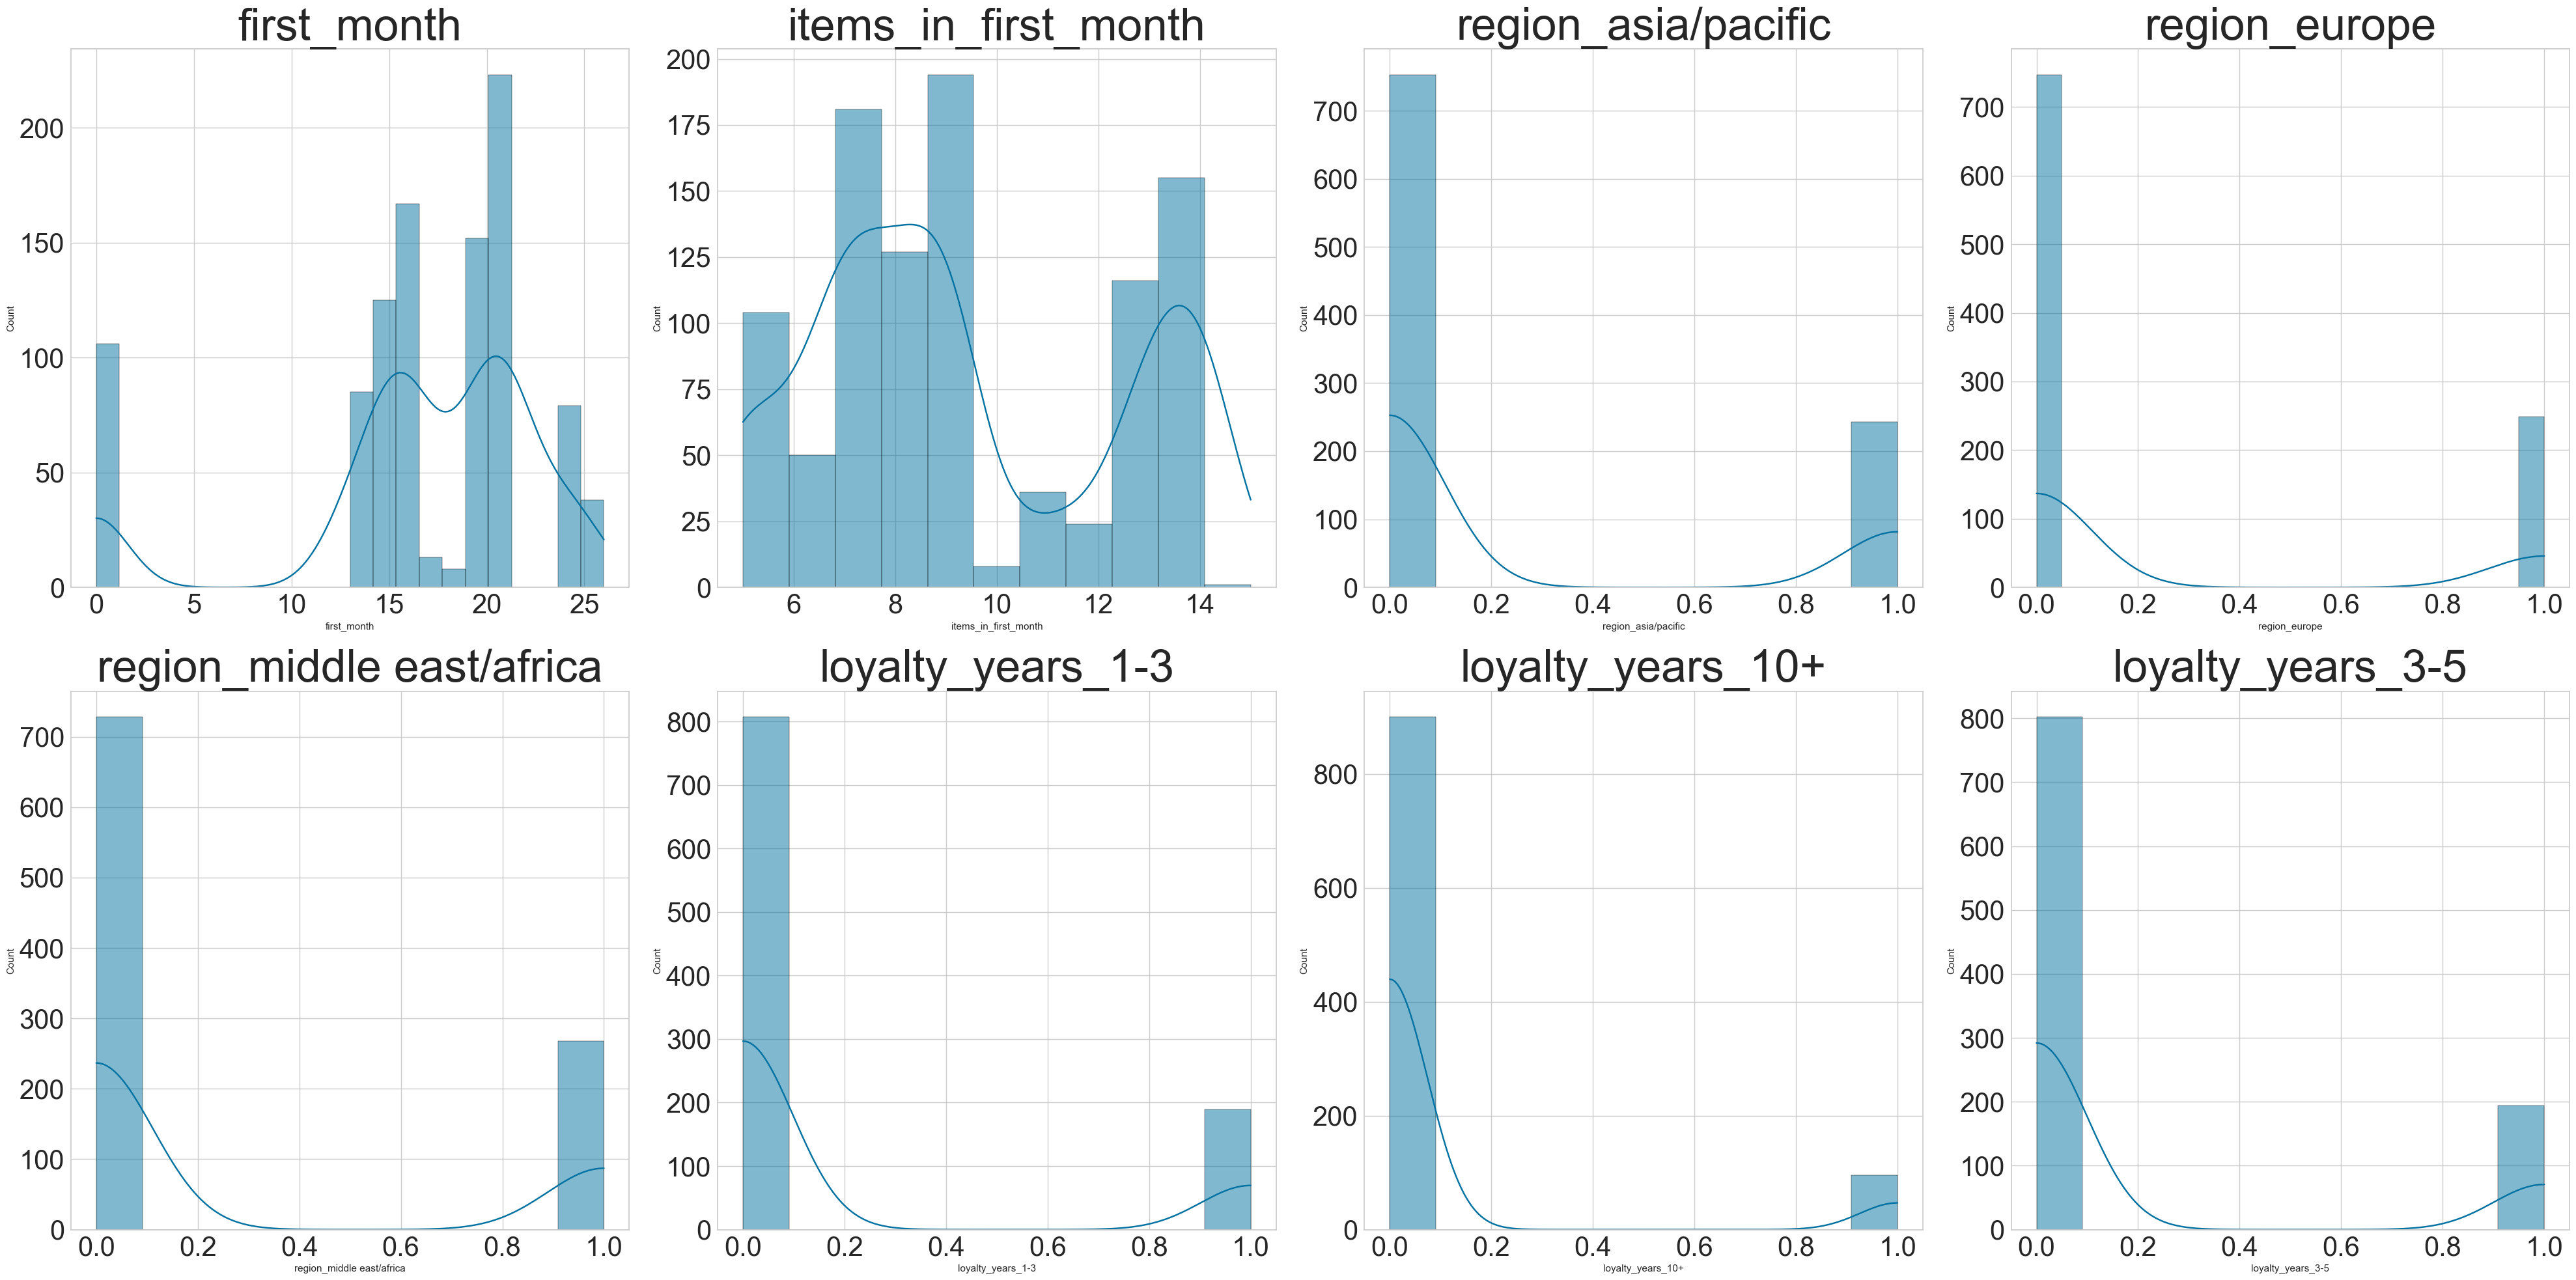

In [67]:
rows = 2
cols = 4

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(40, 20))

col = X_train.columns
index = 0

for i in range(rows):
    for j in range(cols):
        if index >= len(col):
            break
        sns.histplot(X_train[col[index]], ax=ax[i][j], kde=True)
        ax[i][j].set_title(col[index], fontsize=50)
        ax[i][j].tick_params(axis='both', labelsize=30)
        index += 1

plt.tight_layout()
plt.show()


## checking linerity

Checking assumptions for feature: first_month


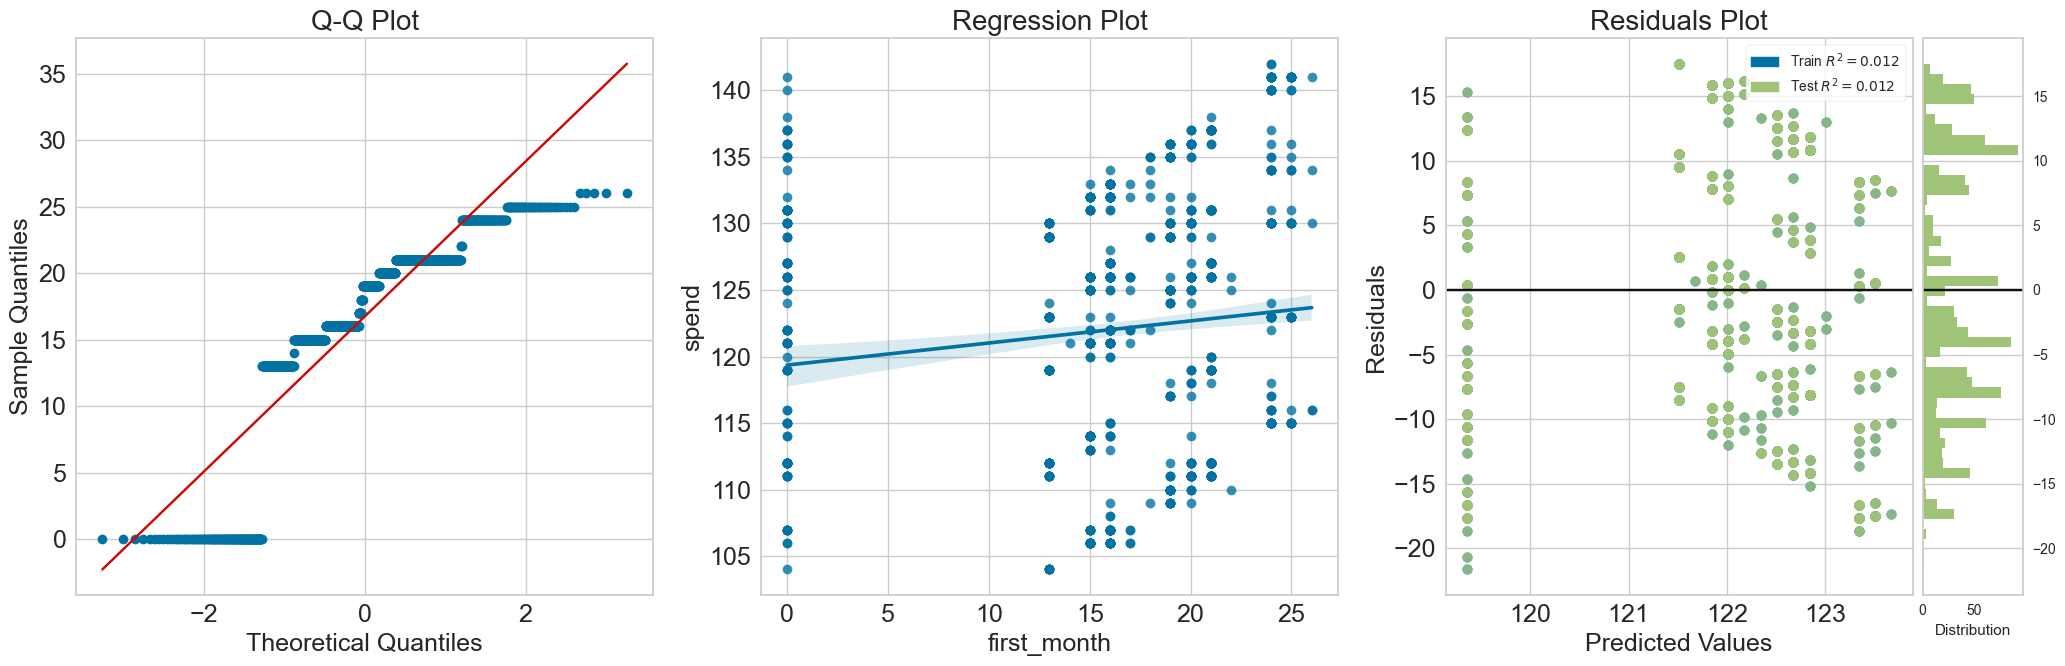

Checking assumptions for feature: items_in_first_month


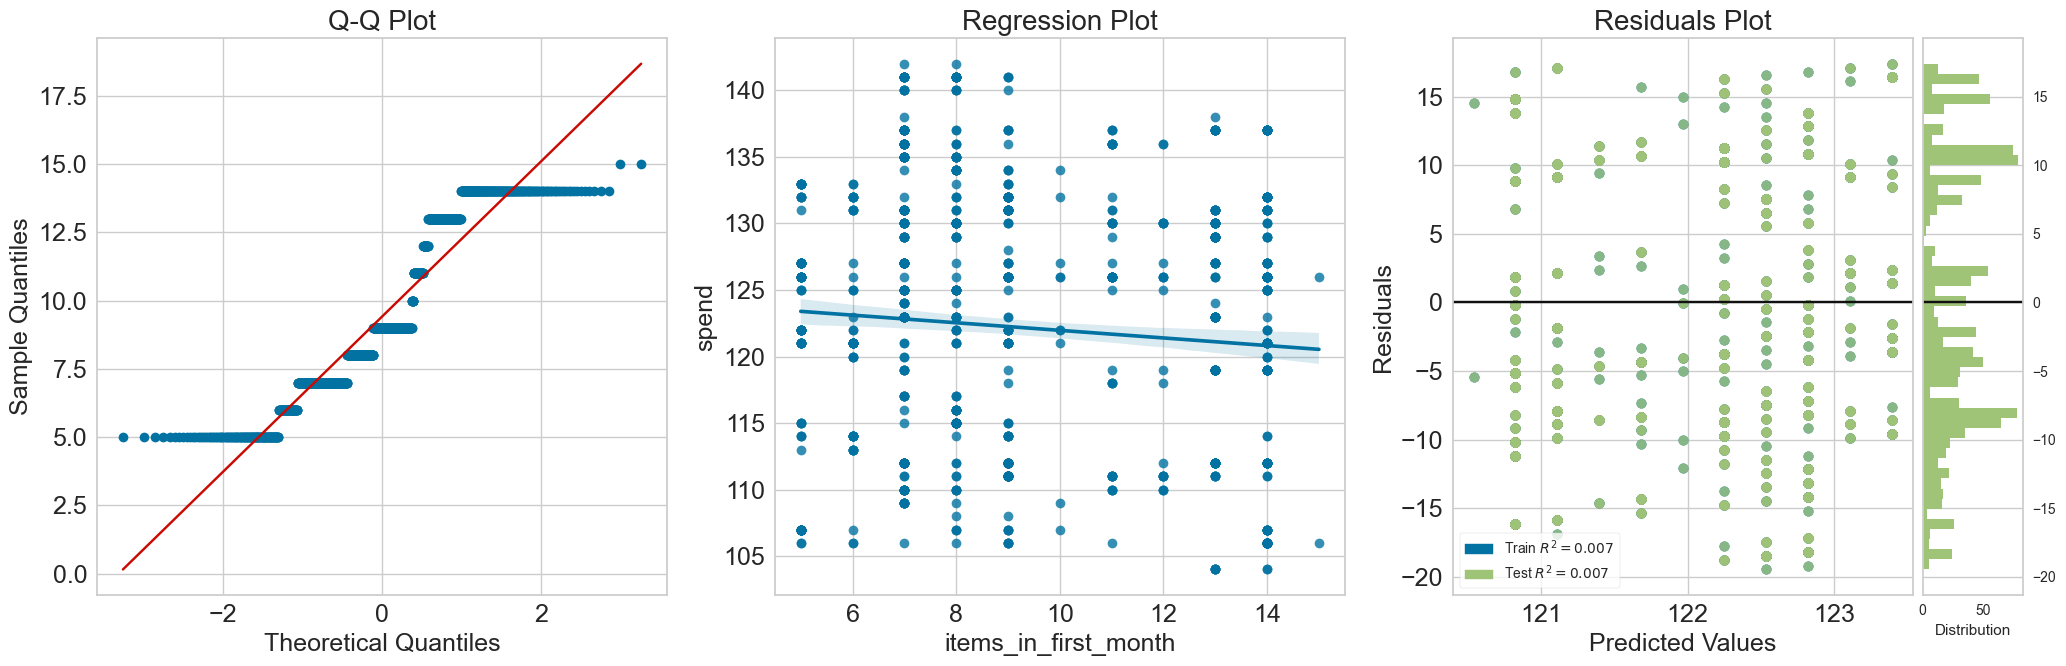

In [70]:
def check_linear_model_assumptions(df, variable):
    plt.rcParams.update({'font.size': 18})  # Set global font size

    fig, axs = plt.subplots(1, 3, figsize=(21, 7))

    # Plot Q-Q plot
    stats.probplot(df[variable], dist='norm', plot=axs[0])
    axs[0].set_title('Q-Q Plot', fontsize=20)
    axs[0].set_xlabel('Theoretical Quantiles', fontsize=18)
    axs[0].set_ylabel('Sample Quantiles', fontsize=18)
    axs[0].tick_params(axis='both', labelsize=18)

    # Plot regression line
    sns.regplot(x=variable, y='spend', data=df, order=1, ax=axs[1])
    axs[1].set_title('Regression Plot', fontsize=20)
    axs[1].set_xlabel(variable, fontsize=18)
    axs[1].set_ylabel('spend', fontsize=18)
    axs[1].tick_params(axis='both', labelsize=18)

    # Perform 5-fold cross-validation and plot residuals
    X = df[[variable]]
    y = df['spend']

    model = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    predictions = cross_val_predict(model, X, y, cv=kf)

    visualizer = ResidualsPlot(model, ax=axs[2])
    visualizer.fit(X, y)  # Fit the training data to the model
    visualizer.score(X, y)  # Evaluate the model on the cross-validated predictions
    visualizer.finalize()

    axs[2].set_title('Residuals Plot', fontsize=20)
    axs[2].set_xlabel('Predicted Values', fontsize=18)
    axs[2].set_ylabel('Residuals', fontsize=18)
    axs[2].tick_params(axis='both', labelsize=18)

    plt.tight_layout()
    plt.show()

features = ['first_month', 'items_in_first_month']
# Loop to call the function for each feature
for feature in features:
    print(f"Checking assumptions for feature: {feature}")
    check_linear_model_assumptions(data_with_dummies, feature)


## Spearman Correlation Matrix Heatmap with clustering

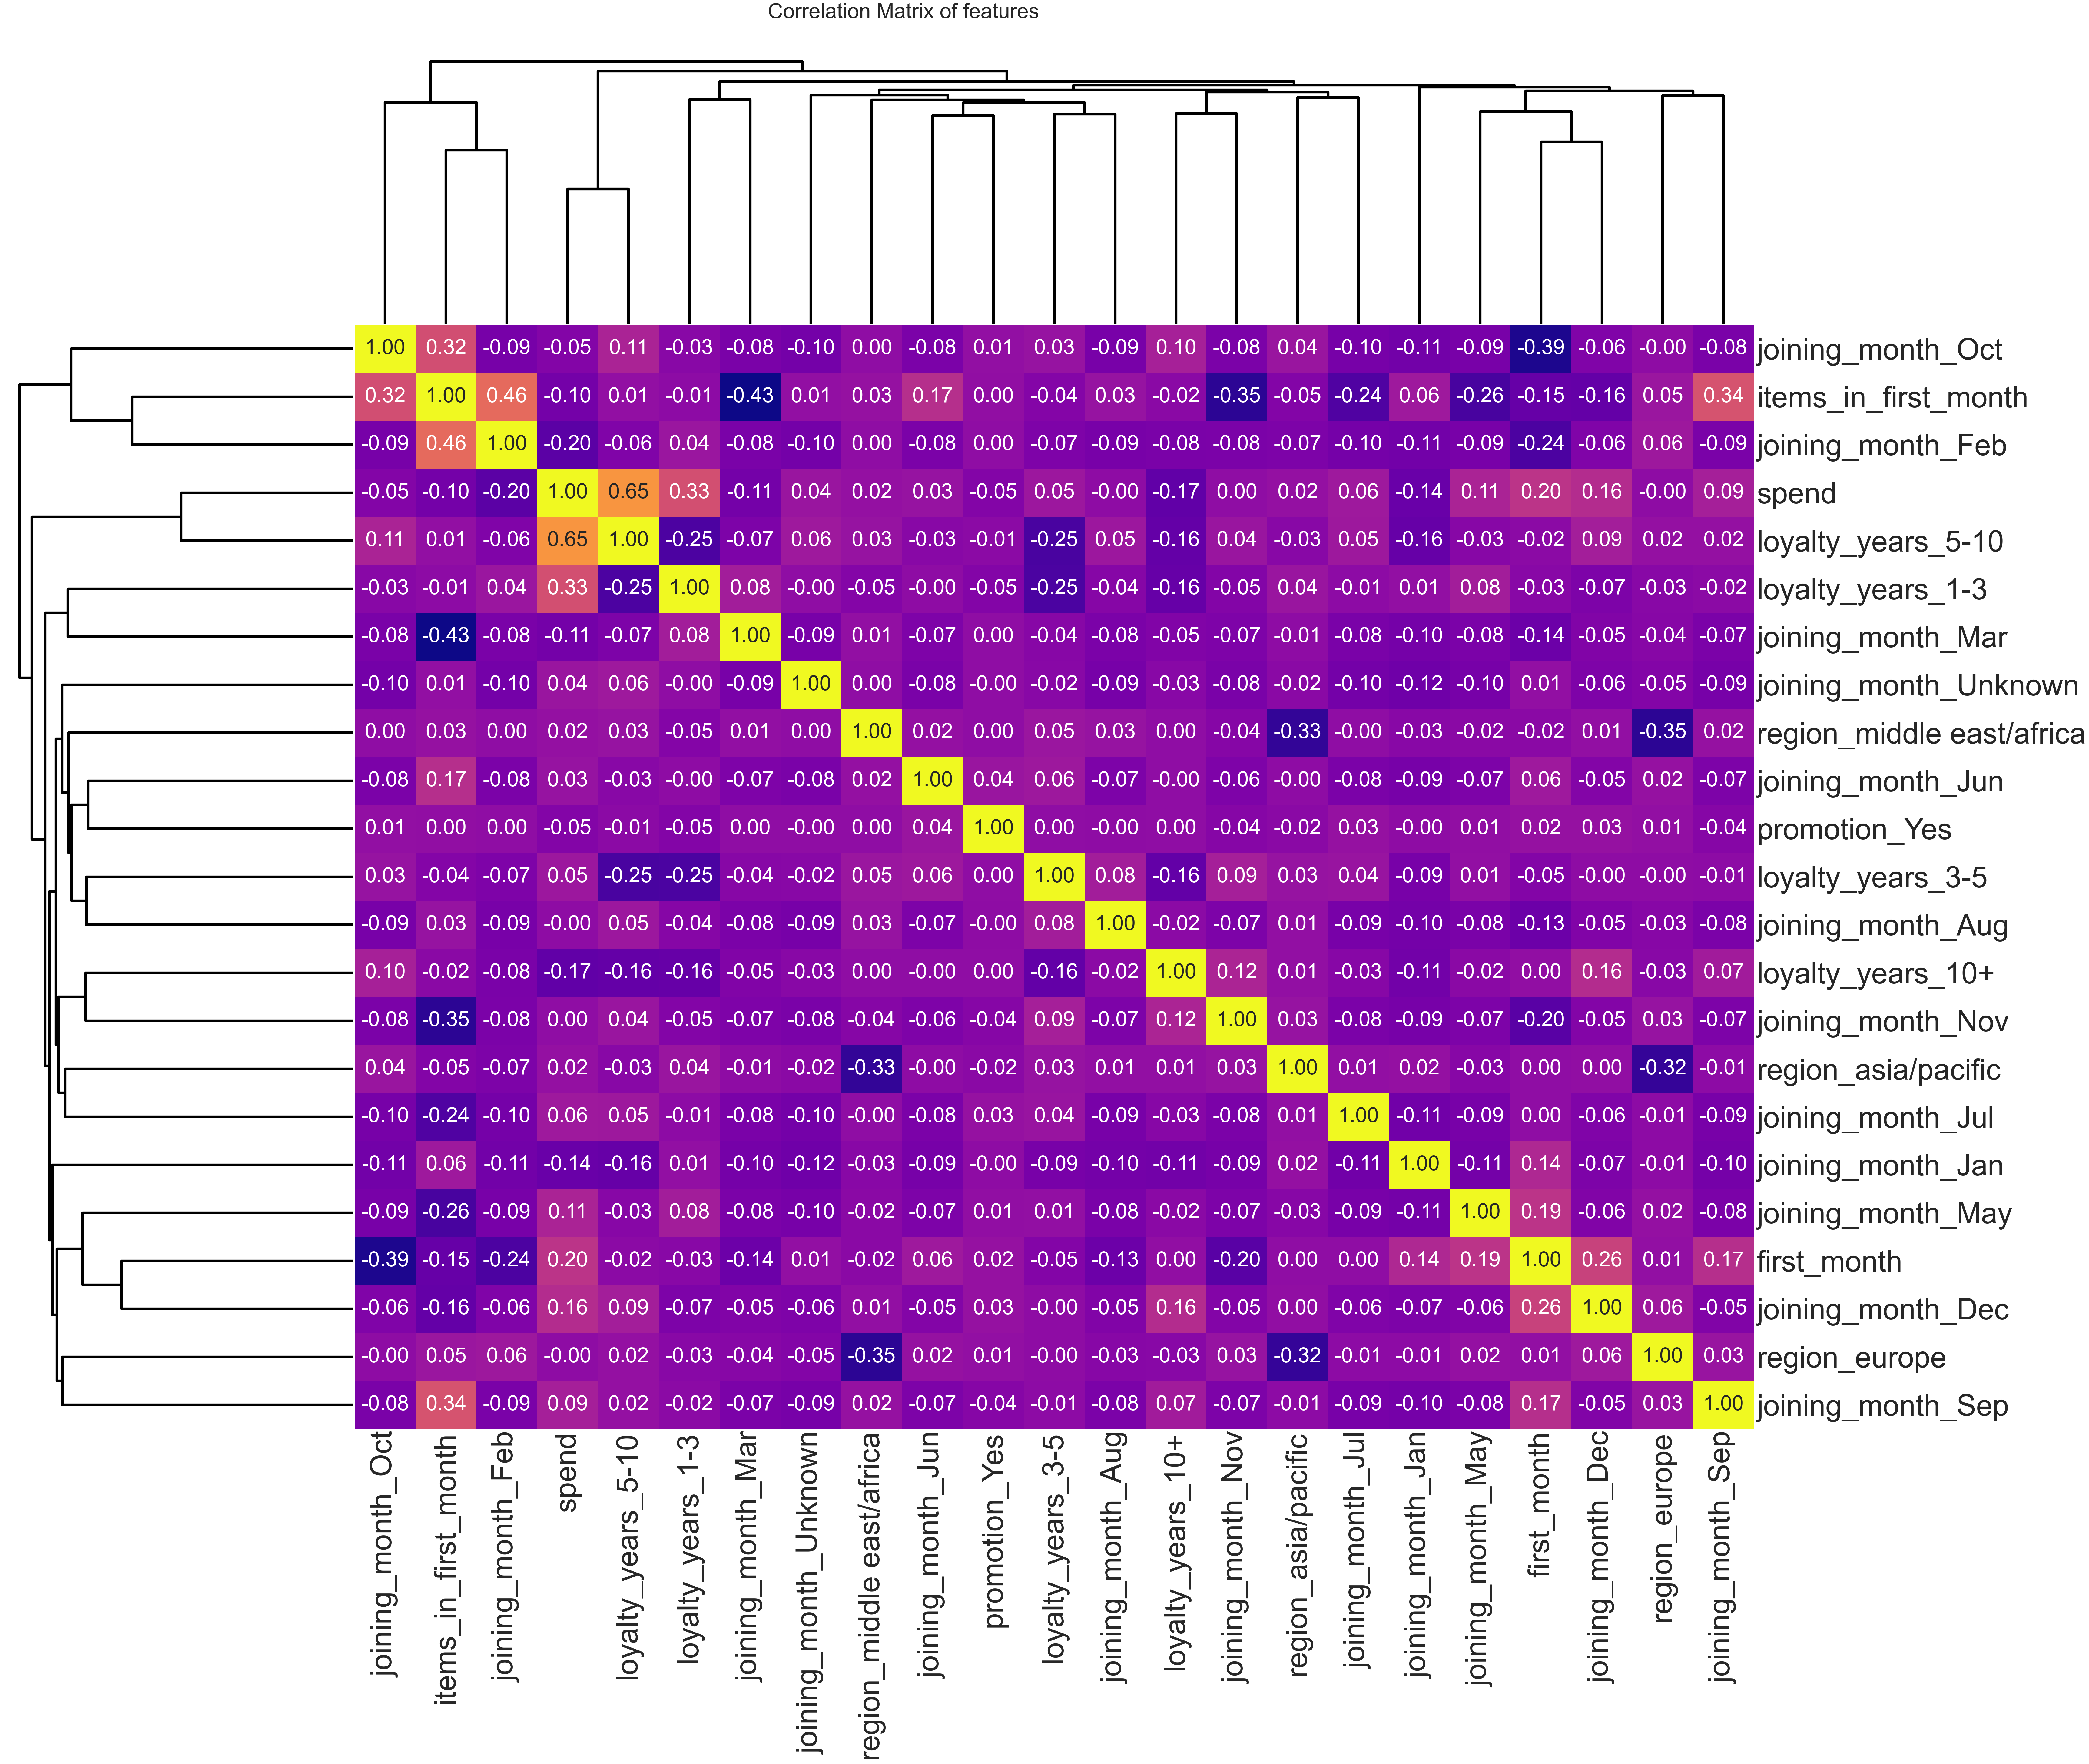

In [72]:
#full data was normalized will use
corrmat = data_with_dummies.corr(method='spearman')

# Create the clustermap with dendrogram
clustermap = sns.clustermap(
    corrmat,
    annot=True,
    annot_kws={'size': 50},
    cmap='plasma',
    fmt='.2f',
    figsize=(60, 50),
    dendrogram_ratio=(.2, .2),
    cbar_pos=None
)

# Customize the dendrogram lines to be solid and black
for ax in [clustermap.ax_row_dendrogram, clustermap.ax_col_dendrogram]:
    for line in ax.collections:
        line.set_color('black')
        line.set_linewidth(6)

# Rotate X and Y axis labels
clustermap.ax_heatmap.set_xticklabels(
    clustermap.ax_heatmap.get_xticklabels(),
    rotation=90,  # Set to 90 degrees for vertical labels
    horizontalalignment='center',
    fontsize=70  # Set font size for X axis labels
)

clustermap.ax_heatmap.set_yticklabels(
    clustermap.ax_heatmap.get_yticklabels(),
    rotation=0,  # Keep as 0 for horizontal labels
    horizontalalignment='left',
    fontsize=70  # Set font size for Y axis labels
)

# Move Y-axis labels further to the right
for label in clustermap.ax_heatmap.get_yticklabels():
    label.set_position((label.get_position()[0], label.get_position()[1] + 0.1))

# Adjust the title (note that plt.title() won't work with sns.clustermap)
clustermap.fig.suptitle('Correlation Matrix of features', size=50)
clustermap.fig.subplots_adjust(top=0.95)

# Show the plot
plt.show()


# 3. Machine learning Models

## LinearRegression Model

In [132]:
kf=10
# Step 1: Train the Model
regressor = LinearRegression()

# Cross-validation
cv_scores = cross_val_score(regressor, X_train, y_train, cv=kf)

# Print scores
print("The R2 is of training of 10 fold: ", cv_scores.round(2))
print("The mean R2 of training of 10 fold: ", np.mean(cv_scores).round(2))
print("The standard deviation of training of 10 fold: ", np.std(cv_scores).round(4))
print("The quantile of training of 10 fold: ", np.quantile(cv_scores, [0.025, 0.975]))

# Fit the model on the entire training set
regressor.fit(X_train, y_train)

# Step 2: Predict on Test Data
predicted_spend = regressor.predict(X_test)


# Step 4: Calculate RMSE
rmse = mean_squared_error(y_test, predicted_spend, squared=False)

# Step 5: Calculate Adjusted R²
n = X_test.shape[0]  # Number of test samples
p = X_test.shape[1]  # Number of features
adjusted_r2 = 1 - ((1 - score) * (n - 1)) / (n - p - 1)

# Print the results
print(f"Root Mean Squared Error (RMSE) for Linear Regression: {rmse:.2f}")
print(f"Adjusted R² for Linear Regression: {adjusted_r2:.2f}")


The R2 is of training of 10 fold:  [0.99 0.98 0.98 0.98 0.99 0.99 0.99 0.99 0.99 0.98]
The mean R2 of training of 10 fold:  0.99
The standard deviation of training of 10 fold:  0.0038
The quantile of training of 10 fold:  [0.97878333 0.99095977]
Root Mean Squared Error (RMSE) for Linear Regression: 1.14
Adjusted R² for Linear Regression: 0.98


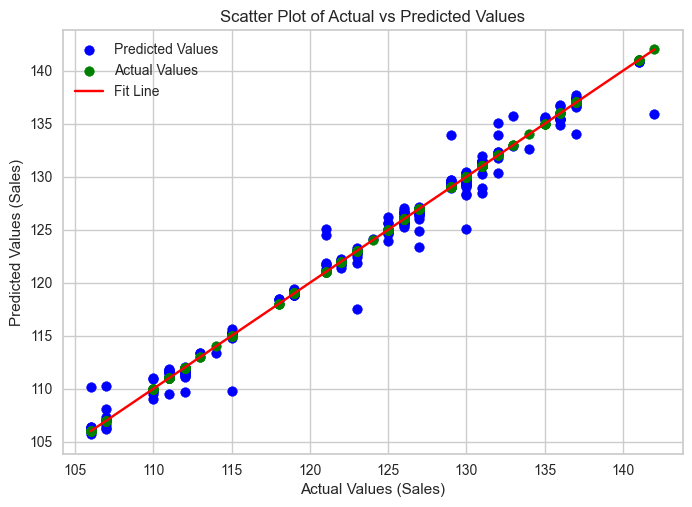

In [130]:
# Step 1: Create scatter plot of actual vs predicted values
plt.scatter(y_test, predicted_spend, color="blue", label="Predicted Values")

# Step 2: Plot actual values (green)
plt.scatter(y_test, y_test, color="green", label="Actual Values")

# Step 3: Plot the fit line (y = x) for reference (where predicted values equal actual values)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", label="Fit Line")

# Step 4: Adding labels and title
plt.xlabel("Actual Values (Sales)")
plt.ylabel("Predicted Values (Sales)")
plt.title("Scatter Plot of Actual vs Predicted Values")

# Step 5: Show legend
plt.legend()

# Step 6: Display the plot
plt.show()


## the Decision Tree Model

In [133]:
# Step 1: Train the Decision Tree Model
regressor_tree = DecisionTreeRegressor(random_state=42)  # Set random_state for reproducibility


# Cross-validation
cv_scores_tree = cross_val_score(regressor_tree, X_train, y_train, cv=kf)

# Print scores
print("The R2 is of training of 10 fold: ", cv_scores_tree.round(2))
print("The mean R2 of training of 10 fold: ", np.mean(cv_scores_tree).round(2))
print("The standard deviation of training of 10 fold: ", np.std(cv_scores_tree).round(4))
print("The quantile of training of 10 fold: ", np.quantile(cv_scores_tree, [0.025, 0.975]))

# Step 2: fit and Predict on Test Data
regressor_tree.fit(X_train, y_train)
predicted_spend_tree = regressor_tree.predict(X_test)
actual_spend = y_test # Actual values from the test set
# Step 3: Calculate R² score (for Decision Tree)
score_t = regressor_tree.score(X_test, y_test)  # R² score for Decision Tree

# Step 4: Calculate RMSE (Root Mean Squared Error)
rmse_tree = mean_squared_error(actual_spend, predicted_spend_tree, squared=False)

# Step 5: Calculate Adjusted R²
n = X_test.shape[0]  # Number of test samples
p = X_test.shape[1]  # Number of features

adjusted_r2_tree = 1 - ((1 - score_t) * (n - 1)) / (n - p - 1)

# Print the results for Decision Tree
print(f"Root Mean Squared Error (RMSE) for Decision Tree Regressor: {rmse_tree:.2f}")
print(f"R² for Decision Tree Regressor: {score_t:.2f}")
print(f"Adjusted R² for Decision Tree Regressor: {adjusted_r2_tree:.2f}")


The R2 is of training of 10 fold:  [0.98 0.99 0.98 0.98 0.98 0.99 0.98 0.99 0.99 1.  ]
The mean R2 of training of 10 fold:  0.99
The standard deviation of training of 10 fold:  0.005
The quantile of training of 10 fold:  [0.97852784 0.9950414 ]
Root Mean Squared Error (RMSE) for Decision Tree Regressor: 0.79
R² for Decision Tree Regressor: 0.99
Adjusted R² for Decision Tree Regressor: 0.99


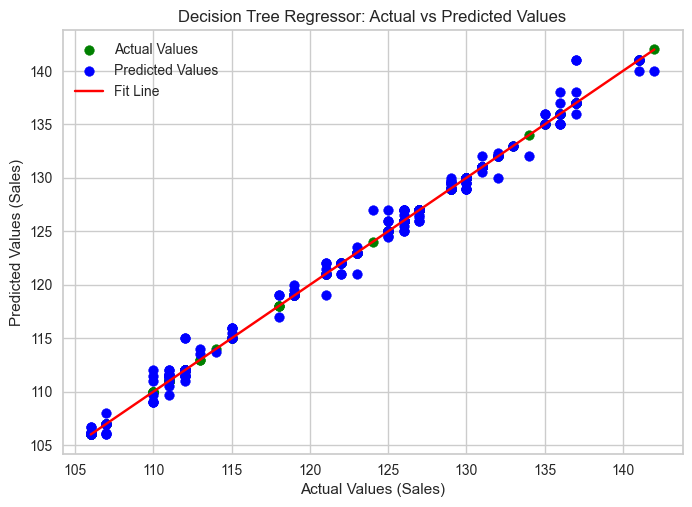

In [134]:
# Step 1: Create scatter plot for actual values (in green)
plt.scatter(y_test, y_test, color="green", label="Actual Values")

# Step 2: Create scatter plot for predicted values (in blue)
plt.scatter(y_test, predicted_spend_tree, color="blue", label="Predicted Values")

# Step 3: Plot the fit line (y = x) for reference (where predicted values equal actual values)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", label="Fit Line")

# Step 4: Adding labels and title
plt.xlabel("Actual Values (Sales)")
plt.ylabel("Predicted Values (Sales)")
plt.title("Decision Tree Regressor: Actual vs Predicted Values")

# Step 5: Show legend
plt.legend()

# Step 6: Display the plot
plt.show()
